In [1]:
import pickle
import re
import warnings
import spacy
from spacy.lang.en import English
from collections import Counter, OrderedDict
import string
import swifter
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz, process
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
stop = stopwords.words('english')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
df.shape

(10158, 6)

In [4]:
df.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


# Data Preprocessing Steps
- remove stop words, numeric values, and punctuation
- lmmetize
- tokenize
- tfdif
- obtain simiarlity scores

In [5]:
# remove stop words, numbers, and punctuation

df['prod_clean'] = df['product_title'].str.lower().apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['prod_clean'] = df['prod_clean'].apply(
    lambda x: x.strip(string.punctuation))
df['prod_clean'] = df['prod_clean'].str.replace('\d+', '')

df['desc_clean'] = df['product_description'].str.lower().fillna('none').apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['desc_clean'] = df['desc_clean'].apply(
    lambda x: x.strip(string.punctuation))
df['desc_clean'] = df['desc_clean'].str.replace('\d+', '')

In [6]:
lemmat = WordNetLemmatizer()
df['prod_lemat'] = df.apply(lambda row: lemmat.lemmatize(row['prod_clean']),
                            axis=1)
df['desc_lemat'] = df.apply(lambda row: lemmat.lemmatize(row['desc_clean']),
                            axis=1)

In [7]:
# tokenize

df['prod_token'] = df.apply(lambda row: word_tokenize(row['prod_lemat']),
                            axis=1)
df['desc_token'] = df.apply(lambda row: word_tokenize(row['desc_lemat']),
                            axis=1)

In [8]:
# combine both product title and description into one feature columns

df['join_text'] = df['prod_token'] + df['desc_token']

In [9]:
# convert back to text string

df['text'] = df['join_text'].apply(lambda x: ' '.join(map(str, x)))

In [10]:
# remvoe duplicated words

df['text_fin'] = (df['text'].str.split().apply(
    lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

In [11]:
# filter out the needed colunm

expo = df[['id', 'query', 'text_fin', 'median_relevance']]

In [12]:
expo.head()

,id,query,text_fin,median_relevance
0,1,bridal shower decorations,accent pillow heart design - red/black red sat...,1
1,2,led christmas lights,set battery operated multi led train christmas...,4
2,4,projector,viewsonic pro dlp multimedia projector none,4
3,5,wine rack,concept housewares wr- solid-wood ceiling/wall...,4
4,7,light bulb,wintergreen lighting christmas led light bulb ...,2


In [13]:
nlp = spacy.load('en_core_web_md')

C:\Users\sit_k\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_md' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [14]:
expo['q_nlp'] = expo['query'].swifter.apply(nlp)

<ipython-input-14-fd5394d5b788>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo['q_nlp'] = expo['query'].swifter.apply(nlp)


In [15]:
expo['t_nlp'] = expo['text_fin'].swifter.apply(nlp)

<ipython-input-15-2b20fe8f33ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo['t_nlp'] = expo['text_fin'].swifter.apply(nlp)


In [16]:
expo['sim'] = [
    expo['q_nlp'][i].similarity(expo['t_nlp'][i]) for i in range(len(expo))
]

<ipython-input-16-16b9705bf3ab>:1: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  expo['sim'] = [expo['q_nlp'][i].similarity(expo['t_nlp'][i]) for i in range(len(expo))]
<ipython-input-16-16b9705bf3ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo['sim'] = [expo['q_nlp'][i].similarity(expo['t_nlp'][i]) for i in range(len(expo))]


In [17]:
expo['fuzzy'] = [
    fuzz.partial_ratio(expo['query'][x], expo['text_fin'][x])
    for x in range(len(expo))
]

<ipython-input-17-3ed92dae19f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo['fuzzy'] = [fuzz.partial_ratio(expo['query'][x], expo['text_fin'][x])


In [18]:
expo['query_len'] = expo['query'].str.count(' ') + 1

<ipython-input-18-7ccd74acd2bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo['query_len'] = expo['query'].str.count(' ')+1


### Exploratory

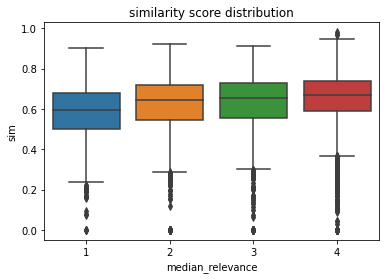

In [19]:
sns.boxplot(x='median_relevance', y='sim', data=expo)
plt.title('similarity score distribution')
plt.show()

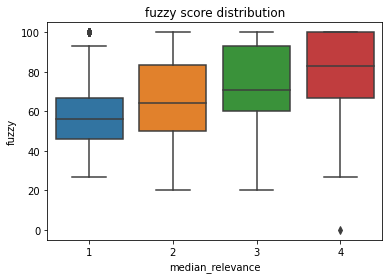

In [21]:
sns.boxplot(x='median_relevance', y='fuzzy', data=expo)
plt.title('fuzzy score distribution')
plt.show()

**Observation** : positive correlation between fuzzywuzzy/similarity scores with median_relevance values.

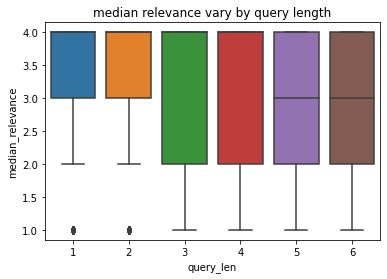

In [23]:
sns.boxplot(x='query_len', y='median_relevance', data=expo)
plt.title('median relevance vary by query length')
plt.show()

In [32]:
expo.groupby(['query_len']).agg({'median_relevance': 'mean'})

,median_relevance
query_len,
1,3.340113
2,3.414203
3,3.152536
4,3.221622
5,2.855072
6,2.913580


**Observations**: Longer search queries have lower median_relevance score on average.

In [24]:
expo['median_relevance'].value_counts(normalize=True)

4    0.607501
3    0.170998
2    0.145304
1    0.076196
Name: median_relevance, dtype: float64

In [25]:
med_rel_1 = expo.query('median_relevance == 1')['query'].to_list()
med_rel_2 = expo.query('median_relevance == 2')['query'].to_list()
med_rel_3 = expo.query('median_relevance == 3')['query'].to_list()
med_rel_4 = expo.query('median_relevance == 4')['query'].to_list()

In [26]:
vect_1 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_1.fit_transform(med_rel_1)
X_1 = vect_1.get_feature_names()

vect_2 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_2.fit_transform(med_rel_2)
X_2 = vect_2.get_feature_names()

vect_3 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_3.fit_transform(med_rel_3)
X_3 = vect_3.get_feature_names()

vect_4 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_4.fit_transform(med_rel_4)
X_4 = vect_4.get_feature_names()

In [27]:
tup_list = list(set(X_1 + X_2 + X_3 + X_4))

In [29]:
with open('data/tup_list.pkl', 'wb') as f:
    pickle.dump(tup_list, f)

In [30]:
for term in tup_list:
    expo[term] = expo['query'].str.contains(term)

<ipython-input-30-2497ddf46b62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expo[term] = expo['query'].str.contains(term)


In [31]:
expo.set_index('id').to_csv('./data/df_clean.csv')